In [1]:
import os
import sys
sys.path.insert(0, '../')

from tqdm.auto import tqdm
tqdm.pandas()

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import re
import seaborn as sns

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
from pytesseract import Output, TesseractError

import easyocr

import keras_ocr

from src.features import build_features

d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Preparation

In [2]:
#verify that cuda is available
import torch
#torch.__version__
torch.cuda.is_available()

True

In [3]:
#paths
kaggle_path = "./../data/raw/ImageAndXML_Data"
rvlcdip_path = "./../data/raw/selected"

#color palette
palette = ["#4e342e", "#5d4037", "#6d4c41", "#8d6e63", "#a1887f", "#d7ccc8"]

In [4]:
#puting all the files name into a list
file_list = []
for file in glob.glob(f"{kaggle_path}/*.tif"):
    file_list.append(file.split('\\')[-1])

#puting all the pictures into a list
picture_list = []
for file in glob.glob(f"{kaggle_path}/*.tif"):
    img = Image.open(file)
    picture_list.append(img)

#puting the content of the target files into a list
text_list = []
for file in glob.glob(f"{kaggle_path}/*_ocr.xml"):
    text_list.append(build_features.parse_xml(file))

#stitching in a dataframe file name, picture and text
df = pd.DataFrame(columns=['filename', 'picture', 'text'])
df['filename'] = file_list
df['picture'] = picture_list
df['text'] = text_list

##### Functions

In [5]:
#function to pickle a dataframe
def pickle_df(df, path):
    df.to_pickle(path)

In [6]:
#function to load a dataframe from pkl
def unpickle_df(path):
    return pd.read_pickle(path)

In [7]:
#function to ocr the pictures with pytesseract
def ocr_pytesseract(pic_series):
    print('OCR with pytesseract')
    ocr_text_tess_list = []
    for pic in tqdm(pic_series):
        ocr_text_tess = pytesseract.image_to_string(pic, config='--psm 3')
        ocr_text_tess = re.sub(r'\n', ' ', ocr_text_tess)
        ocr_text_tess_list.append(ocr_text_tess)

    return ocr_text_tess_list

In [8]:
#function to ocr the pictures with easyocr
def ocr_easyocr(pic_series):
    print('OCR with easyocr')
    ocr_text_easyocr_list = []

    reader = easyocr.Reader(['en'], gpu=True)

    for file in tqdm(pic_series):
        ocr_text_easyocr = reader.readtext(f"{kaggle_path}/{file}")
        ocr_text_easyocr = [text[1] for text in ocr_text_easyocr]
        ocr_text_easyocr = ' '.join(ocr_text_easyocr)
        ocr_text_easyocr_list.append(ocr_text_easyocr)

    return ocr_text_easyocr_list

In [9]:
#function to ocr the pictures with keras_ocr
def ocr_keras_ocr(pic_series):
    print('OCR with keras_ocr')
    ocr_text_keras_ocr_list = []

    pipeline = keras_ocr.pipeline.Pipeline()

    for pic in tqdm(pic_series):
        gray_image = np.array(pic)
        color_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
        result = pipeline.recognize([color_image])

        text = ""
        for t in result[0]:
            text += t[0] + " "
        ocr_text_keras_ocr_list.append(text)

    return ocr_text_keras_ocr_list

In [10]:
#function to calculate a similarity score between the text and the ocr_text
def similarity_score(text, ocr_text):
    print('Calculating similarity score')
    similarity_list = []
    for i in tqdm(range(len(text))):
        similarity_list.append(build_features.similarity_score(text.iloc[i], ocr_text.iloc[i]))

    return similarity_list

In [11]:
#function to calculate the jaccard index between the text and the ocr_text
def jaccard_index(text, ocr_text):
    print('Calculating Jaccard index')
    jaccard_list = []

    for i in tqdm(range(len(text))):
        jaccard_list.append(build_features.jaccard_index(text.iloc[i], ocr_text.iloc[i]))

    return jaccard_list

In [12]:
#function to calculate the tfidf similarity between the text and the ocr_text
def tfidf_score(text, ocr_text):
    print('Calculating tfidf similarity')
    #creating a corpus of words
    corpus = []
    for t in text:
        for word in t.split():
            if word not in corpus:
                corpus.append(word)
    for t in ocr_text:
        for word in t.split():
            if word not in corpus:
                corpus.append(word)

    #calculting the tfidf similarity
    tfidf_similarity_list = []
    for i in tqdm(range(len(text))):
        tfidf_similarity_list.append(build_features.tfidf_similarity(corpus, text.iloc[i], ocr_text.iloc[i]))

    return tfidf_similarity_list

In [13]:
#function to clean the texts
def clean_text(text):
    print('Cleaning the text')
    clean_text_list = []
    for text in tqdm(text):
        clean_text_list.append(build_features.text_cleaning(text))
    return clean_text_list

In [14]:
#function to calculate the text orientation
def get_text_orientation(image):
    print('Getting text orientation')
    try:
        data = pytesseract.image_to_osd(image, output_type=Output.DICT)
        rotate_angle = data['rotate']
        return rotate_angle
    except TesseractError:
        rotate_angle = 0
        return rotate_angle

In [15]:
#function to rotate the image
def rotate_image(image, angle):
    print('Rotating the image')
    image = image.rotate(angle)
    return image

In [16]:
#function to resize the image
def resize_image(image):
    print('Resizing the image')
    image = image.resize((1000, 1000))
    return image

##### On Commence par calculer differentes metriques pour les deux methodes d'ocr

In [17]:
#Rotating and resizing the pictures
df['angle'] = df.picture.apply(get_text_orientation)
df['picture'] = df.apply(lambda x: rotate_image(x['picture'], x['angle']), axis=1)
df['picture'] = df.apply(lambda x: resize_image(x['picture']), axis=1)

#ocr with pytesseract and easyocr
df['ocr_text_tess'] = ocr_pytesseract(df.picture)
df['ocr_text_easyocr'] = ocr_easyocr(df.filename)
df['ocr_text_keras_ocr'] = ocr_keras_ocr(df.picture)


#saving the dataframe
pickle_df(df, './../data/raw/df.pkl')
df = unpickle_df('./../data/raw/df.pkl')

#calculating all the scores
df['similarity_tess'] = similarity_score(df.text, df.ocr_text_tess)
df['similarity_easyocr'] = similarity_score(df.text, df.ocr_text_easyocr)
df['similarity_keras_ocr'] = similarity_score(df.text, df.ocr_text_keras_ocr)

df['jaccard_tess'] = jaccard_index(df.text, df.ocr_text_tess)
df['jaccard_easyocr'] = jaccard_index(df.text, df.ocr_text_easyocr)
df['jaccard_keras_ocr'] = jaccard_index(df.text, df.ocr_text_keras_ocr)

df['tfidf_tess'] = tfidf_score(df.text, df.ocr_text_tess)
df['tfidf_easyocr'] = tfidf_score(df.text, df.ocr_text_easyocr)
df['tfidf_keras_ocr'] = tfidf_score(df.text, df.ocr_text_keras_ocr)

Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation
Getting text orientation


100%|██████████| 520/520 [04:28<00:00,  1.94it/s]


OCR with easyocr


100%|██████████| 520/520 [09:27<00:00,  1.09s/it]


OCR with keras_ocr
Looking for C:\Users\Julien\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Julien\.keras-ocr\crnn_kurapan.h5


  0%|          | 0/520 [00:00<?, ?it/s]

3/3 [==============================] - 6s 985ms/step


  0%|          | 1/520 [00:25<3:36:35, 25.04s/it]

8/8 [==============================] - 7s 892ms/step


  0%|          | 2/520 [00:42<2:56:06, 20.40s/it]

8/8 [==============================] - 7s 882ms/step


  1%|          | 3/520 [00:59<2:42:43, 18.88s/it]

7/7 [==============================] - 7s 959ms/step


  1%|          | 4/520 [01:15<2:34:25, 17.96s/it]

4/4 [==============================] - 4s 919ms/step


  1%|          | 5/520 [01:28<2:18:51, 16.18s/it]

9/9 [==============================] - 9s 1s/step


  1%|          | 6/520 [01:47<2:27:07, 17.17s/it]

7/7 [==============================] - 6s 850ms/step


  1%|▏         | 7/520 [02:03<2:22:49, 16.70s/it]

5/5 [==============================] - 4s 801ms/step


  2%|▏         | 8/520 [02:17<2:14:03, 15.71s/it]

3/3 [==============================] - 3s 775ms/step


  2%|▏         | 9/520 [02:28<2:02:55, 14.43s/it]

5/5 [==============================] - 4s 761ms/step


  2%|▏         | 10/520 [02:42<1:59:46, 14.09s/it]

5/5 [==============================] - 5s 895ms/step


  2%|▏         | 11/520 [02:56<1:59:29, 14.08s/it]

4/4 [==============================] - 4s 922ms/step


  2%|▏         | 12/520 [03:09<1:56:36, 13.77s/it]

5/5 [==============================] - 5s 888ms/step


  2%|▎         | 13/520 [03:23<1:56:47, 13.82s/it]

3/3 [==============================] - 2s 730ms/step


  3%|▎         | 14/520 [03:34<1:50:39, 13.12s/it]

3/3 [==============================] - 2s 673ms/step


  3%|▎         | 15/520 [03:46<1:46:11, 12.62s/it]

6/6 [==============================] - 5s 845ms/step


  3%|▎         | 16/520 [04:00<1:51:17, 13.25s/it]

8/8 [==============================] - 7s 914ms/step


  3%|▎         | 17/520 [04:18<2:00:57, 14.43s/it]

5/5 [==============================] - 4s 851ms/step


  3%|▎         | 18/520 [04:31<1:58:59, 14.22s/it]

5/5 [==============================] - 5s 918ms/step


  4%|▎         | 19/520 [04:45<1:58:25, 14.18s/it]

4/4 [==============================] - 4s 922ms/step


  4%|▍         | 20/520 [04:58<1:55:20, 13.84s/it]

5/5 [==============================] - 5s 914ms/step


  4%|▍         | 21/520 [05:13<1:55:39, 13.91s/it]

4/4 [==============================] - 3s 746ms/step


  4%|▍         | 22/520 [05:25<1:51:44, 13.46s/it]

9/9 [==============================] - 9s 954ms/step


  4%|▍         | 23/520 [05:44<2:04:31, 15.03s/it]

9/9 [==============================] - 9s 992ms/step


  5%|▍         | 24/520 [06:03<2:15:14, 16.36s/it]

3/3 [==============================] - 3s 825ms/step


  5%|▍         | 25/520 [06:15<2:04:28, 15.09s/it]

3/3 [==============================] - 2s 718ms/step


  5%|▌         | 26/520 [06:27<1:56:30, 14.15s/it]

3/3 [==============================] - 2s 649ms/step


  5%|▌         | 27/520 [06:39<1:50:17, 13.42s/it]

5/5 [==============================] - 5s 879ms/step


  5%|▌         | 28/520 [06:53<1:51:52, 13.64s/it]

2/2 [==============================] - 2s 928ms/step


  6%|▌         | 29/520 [07:04<1:45:39, 12.91s/it]

7/7 [==============================] - 6s 915ms/step


  6%|▌         | 30/520 [07:21<1:53:53, 13.95s/it]

4/4 [==============================] - 3s 761ms/step


  6%|▌         | 31/520 [07:33<1:50:41, 13.58s/it]

3/3 [==============================] - 3s 877ms/step


  6%|▌         | 32/520 [07:46<1:47:00, 13.16s/it]

4/4 [==============================] - 4s 953ms/step


  6%|▋         | 33/520 [07:59<1:47:23, 13.23s/it]

7/7 [==============================] - 6s 881ms/step


  7%|▋         | 34/520 [08:15<1:54:26, 14.13s/it]

2/2 [==============================] - 2s 642ms/step


  7%|▋         | 35/520 [08:26<1:46:31, 13.18s/it]

4/4 [==============================] - 4s 910ms/step


  7%|▋         | 36/520 [08:39<1:46:38, 13.22s/it]

2/2 [==============================] - 2s 770ms/step


  7%|▋         | 37/520 [08:51<1:41:25, 12.60s/it]

3/3 [==============================] - 3s 887ms/step


  7%|▋         | 38/520 [09:03<1:40:10, 12.47s/it]

9/9 [==============================] - 8s 924ms/step


  8%|▊         | 39/520 [09:21<1:54:51, 14.33s/it]

4/4 [==============================] - 3s 747ms/step


  8%|▊         | 40/520 [09:34<1:50:36, 13.83s/it]

3/3 [==============================] - 3s 850ms/step


  8%|▊         | 41/520 [09:46<1:46:07, 13.29s/it]

5/5 [==============================] - 4s 869ms/step


  8%|▊         | 42/520 [10:00<1:47:39, 13.51s/it]

5/5 [==============================] - 4s 844ms/step


  8%|▊         | 43/520 [10:14<1:48:25, 13.64s/it]

6/6 [==============================] - 6s 1s/step


  8%|▊         | 44/520 [10:30<1:53:52, 14.35s/it]

4/4 [==============================] - 3s 783ms/step


  9%|▊         | 45/520 [10:43<1:50:18, 13.93s/it]

9/9 [==============================] - 9s 1s/step


  9%|▉         | 46/520 [11:04<2:06:09, 15.97s/it]

5/5 [==============================] - 5s 1s/step


  9%|▉         | 47/520 [11:19<2:03:35, 15.68s/it]

6/6 [==============================] - 6s 955ms/step


  9%|▉         | 48/520 [11:35<2:04:18, 15.80s/it]

5/5 [==============================] - 5s 881ms/step


  9%|▉         | 49/520 [11:49<2:00:11, 15.31s/it]

5/5 [==============================] - 5s 886ms/step


 10%|▉         | 50/520 [12:03<1:57:07, 14.95s/it]

3/3 [==============================] - 3s 983ms/step


 10%|▉         | 51/520 [12:15<1:50:34, 14.15s/it]

7/7 [==============================] - 7s 956ms/step


 10%|█         | 52/520 [12:32<1:56:12, 14.90s/it]

7/7 [==============================] - 6s 903ms/step


 10%|█         | 53/520 [12:48<1:59:06, 15.30s/it]

3/3 [==============================] - 3s 1s/step


 10%|█         | 54/520 [13:01<1:52:21, 14.47s/it]

5/5 [==============================] - 5s 910ms/step


 11%|█         | 55/520 [13:15<1:51:39, 14.41s/it]

3/3 [==============================] - 3s 778ms/step


 11%|█         | 56/520 [13:27<1:45:44, 13.67s/it]

4/4 [==============================] - 3s 823ms/step


 11%|█         | 57/520 [13:40<1:44:02, 13.48s/it]

4/4 [==============================] - 3s 716ms/step


 11%|█         | 58/520 [13:53<1:41:39, 13.20s/it]

4/4 [==============================] - 4s 1s/step


 11%|█▏        | 59/520 [14:06<1:42:29, 13.34s/it]

4/4 [==============================] - 4s 1s/step


 12%|█▏        | 60/520 [14:20<1:42:56, 13.43s/it]

5/5 [==============================] - 4s 874ms/step


 12%|█▏        | 61/520 [14:34<1:44:20, 13.64s/it]

3/3 [==============================] - 3s 997ms/step


 12%|█▏        | 62/520 [14:46<1:41:15, 13.27s/it]

3/3 [==============================] - 2s 625ms/step


 12%|█▏        | 63/520 [14:58<1:37:02, 12.74s/it]

5/5 [==============================] - 4s 813ms/step


 12%|█▏        | 64/520 [15:12<1:39:18, 13.07s/it]

3/3 [==============================] - 3s 1s/step


 12%|█▎        | 65/520 [15:24<1:37:36, 12.87s/it]

5/5 [==============================] - 5s 936ms/step


 13%|█▎        | 66/520 [15:39<1:41:00, 13.35s/it]

4/4 [==============================] - 4s 949ms/step


 13%|█▎        | 67/520 [15:52<1:41:03, 13.38s/it]

4/4 [==============================] - 3s 750ms/step


 13%|█▎        | 68/520 [16:05<1:39:12, 13.17s/it]

4/4 [==============================] - 3s 832ms/step


 13%|█▎        | 69/520 [16:18<1:38:23, 13.09s/it]

3/3 [==============================] - 3s 942ms/step


 13%|█▎        | 70/520 [16:30<1:36:16, 12.84s/it]

6/6 [==============================] - 6s 1s/step


 14%|█▎        | 71/520 [16:46<1:42:57, 13.76s/it]

3/3 [==============================] - 3s 978ms/step


 14%|█▍        | 72/520 [16:58<1:39:28, 13.32s/it]

4/4 [==============================] - 4s 859ms/step


 14%|█▍        | 73/520 [17:11<1:38:38, 13.24s/it]

8/8 [==============================] - 8s 974ms/step


 14%|█▍        | 74/520 [17:29<1:48:44, 14.63s/it]

4/4 [==============================] - 3s 712ms/step


 14%|█▍        | 75/520 [17:42<1:43:49, 14.00s/it]

3/3 [==============================] - 2s 720ms/step


 15%|█▍        | 76/520 [17:53<1:38:26, 13.30s/it]

3/3 [==============================] - 3s 1s/step


 15%|█▍        | 77/520 [18:06<1:36:38, 13.09s/it]

5/5 [==============================] - 5s 906ms/step


 15%|█▌        | 78/520 [18:20<1:38:56, 13.43s/it]

5/5 [==============================] - 4s 849ms/step


 15%|█▌        | 79/520 [18:34<1:39:57, 13.60s/it]

5/5 [==============================] - 4s 803ms/step


 15%|█▌        | 80/520 [18:48<1:40:14, 13.67s/it]

4/4 [==============================] - 4s 843ms/step


 16%|█▌        | 81/520 [19:01<1:38:31, 13.47s/it]

3/3 [==============================] - 3s 957ms/step


 16%|█▌        | 82/520 [19:13<1:35:33, 13.09s/it]

5/5 [==============================] - 5s 963ms/step


 16%|█▌        | 83/520 [19:28<1:38:23, 13.51s/it]

7/7 [==============================] - 7s 948ms/step


 16%|█▌        | 84/520 [19:44<1:44:49, 14.43s/it]

7/7 [==============================] - 7s 922ms/step


 16%|█▋        | 85/520 [20:01<1:48:49, 15.01s/it]

4/4 [==============================] - 4s 998ms/step


 17%|█▋        | 86/520 [20:14<1:45:10, 14.54s/it]

5/5 [==============================] - 5s 964ms/step


 17%|█▋        | 87/520 [20:29<1:44:51, 14.53s/it]

3/3 [==============================] - 3s 827ms/step


 17%|█▋        | 88/520 [20:40<1:38:57, 13.75s/it]

3/3 [==============================] - 3s 1s/step


 17%|█▋        | 89/520 [20:53<1:35:51, 13.35s/it]

4/4 [==============================] - 3s 737ms/step


 17%|█▋        | 90/520 [21:06<1:34:08, 13.14s/it]

4/4 [==============================] - 3s 816ms/step


 18%|█▊        | 91/520 [21:18<1:33:20, 13.05s/it]

4/4 [==============================] - 3s 757ms/step


 18%|█▊        | 92/520 [21:31<1:32:18, 12.94s/it]

4/4 [==============================] - 4s 1s/step


 18%|█▊        | 93/520 [21:45<1:33:36, 13.15s/it]

2/2 [==============================] - 2s 921ms/step


 18%|█▊        | 94/520 [21:56<1:29:13, 12.57s/it]

3/3 [==============================] - 3s 859ms/step


 18%|█▊        | 95/520 [22:08<1:27:52, 12.41s/it]

2/2 [==============================] - 2s 847ms/step


 18%|█▊        | 96/520 [22:19<1:24:35, 11.97s/it]

2/2 [==============================] - 2s 906ms/step


 19%|█▊        | 97/520 [22:30<1:22:32, 11.71s/it]

4/4 [==============================] - 3s 701ms/step


 19%|█▉        | 98/520 [22:43<1:24:16, 11.98s/it]

4/4 [==============================] - 4s 856ms/step


 19%|█▉        | 99/520 [22:56<1:26:33, 12.34s/it]

3/3 [==============================] - 3s 1s/step


 19%|█▉        | 100/520 [23:08<1:26:28, 12.35s/it]

5/5 [==============================] - 5s 887ms/step


 19%|█▉        | 101/520 [23:22<1:30:07, 12.91s/it]

4/4 [==============================] - 4s 990ms/step


 20%|█▉        | 102/520 [23:36<1:31:12, 13.09s/it]

2/2 [==============================] - 2s 964ms/step


 20%|█▉        | 103/520 [23:47<1:27:10, 12.54s/it]

2/2 [==============================] - 2s 1s/step


 20%|██        | 104/520 [23:58<1:24:25, 12.18s/it]

5/5 [==============================] - 5s 993ms/step


 20%|██        | 105/520 [24:13<1:29:09, 12.89s/it]

2/2 [==============================] - 2s 697ms/step


 20%|██        | 106/520 [24:24<1:24:47, 12.29s/it]

5/5 [==============================] - 4s 797ms/step


 21%|██        | 107/520 [24:38<1:27:35, 12.72s/it]

4/4 [==============================] - 3s 719ms/step


 21%|██        | 108/520 [24:50<1:27:04, 12.68s/it]

3/3 [==============================] - 2s 566ms/step


 21%|██        | 109/520 [25:02<1:24:12, 12.29s/it]

2/2 [==============================] - 2s 927ms/step


 21%|██        | 110/520 [25:13<1:21:41, 11.95s/it]

4/4 [==============================] - 4s 868ms/step


 21%|██▏       | 111/520 [25:26<1:23:57, 12.32s/it]

5/5 [==============================] - 5s 1s/step


 22%|██▏       | 112/520 [25:41<1:28:53, 13.07s/it]

4/4 [==============================] - 4s 895ms/step


 22%|██▏       | 113/520 [25:54<1:28:50, 13.10s/it]

7/7 [==============================] - 7s 994ms/step


 22%|██▏       | 114/520 [26:11<1:36:23, 14.25s/it]

6/6 [==============================] - 5s 848ms/step


 22%|██▏       | 115/520 [26:26<1:37:36, 14.46s/it]

6/6 [==============================] - 5s 867ms/step


 22%|██▏       | 116/520 [26:41<1:38:52, 14.68s/it]

4/4 [==============================] - 4s 836ms/step


 22%|██▎       | 117/520 [26:54<1:35:14, 14.18s/it]

6/6 [==============================] - 6s 908ms/step


 23%|██▎       | 118/520 [27:09<1:37:10, 14.50s/it]

5/5 [==============================] - 4s 815ms/step


 23%|██▎       | 119/520 [27:23<1:35:34, 14.30s/it]

5/5 [==============================] - 5s 905ms/step


 23%|██▎       | 120/520 [27:37<1:35:13, 14.28s/it]

5/5 [==============================] - 4s 844ms/step


 23%|██▎       | 121/520 [27:51<1:34:17, 14.18s/it]

5/5 [==============================] - 5s 977ms/step


 23%|██▎       | 122/520 [28:06<1:34:54, 14.31s/it]

5/5 [==============================] - 5s 1s/step


 24%|██▎       | 123/520 [28:21<1:35:42, 14.46s/it]

5/5 [==============================] - 5s 1s/step


 24%|██▍       | 124/520 [28:36<1:36:11, 14.57s/it]

6/6 [==============================] - 6s 1s/step


 24%|██▍       | 125/520 [28:52<1:39:11, 15.07s/it]

5/5 [==============================] - 5s 954ms/step


 24%|██▍       | 126/520 [29:06<1:37:49, 14.90s/it]

6/6 [==============================] - 6s 1s/step


 24%|██▍       | 127/520 [29:22<1:39:21, 15.17s/it]

5/5 [==============================] - 5s 967ms/step


 25%|██▍       | 128/520 [29:37<1:37:55, 14.99s/it]

6/6 [==============================] - 5s 833ms/step


 25%|██▍       | 129/520 [29:51<1:37:21, 14.94s/it]

5/5 [==============================] - 4s 813ms/step


 25%|██▌       | 130/520 [30:05<1:34:57, 14.61s/it]

4/4 [==============================] - 3s 793ms/step


 25%|██▌       | 131/520 [30:18<1:31:21, 14.09s/it]

6/6 [==============================] - 5s 843ms/step


 25%|██▌       | 132/520 [30:33<1:32:43, 14.34s/it]

4/4 [==============================] - 4s 986ms/step


 26%|██▌       | 133/520 [30:47<1:30:45, 14.07s/it]

6/6 [==============================] - 6s 1s/step


 26%|██▌       | 134/520 [31:03<1:34:09, 14.63s/it]

5/5 [==============================] - 5s 880ms/step


 26%|██▌       | 135/520 [31:17<1:32:59, 14.49s/it]

4/4 [==============================] - 4s 989ms/step


 26%|██▌       | 136/520 [31:30<1:30:47, 14.19s/it]

4/4 [==============================] - 3s 823ms/step


 26%|██▋       | 137/520 [31:43<1:28:09, 13.81s/it]

6/6 [==============================] - 6s 940ms/step


 27%|██▋       | 138/520 [31:58<1:30:56, 14.28s/it]

5/5 [==============================] - 5s 928ms/step


 27%|██▋       | 139/520 [32:13<1:30:39, 14.28s/it]

5/5 [==============================] - 4s 874ms/step


 27%|██▋       | 140/520 [32:27<1:29:57, 14.20s/it]

6/6 [==============================] - 6s 999ms/step


 27%|██▋       | 141/520 [32:43<1:32:43, 14.68s/it]

4/4 [==============================] - 3s 801ms/step


 27%|██▋       | 142/520 [32:56<1:29:12, 14.16s/it]

5/5 [==============================] - 4s 796ms/step


 28%|██▊       | 143/520 [33:09<1:28:04, 14.02s/it]

7/7 [==============================] - 6s 887ms/step


 28%|██▊       | 144/520 [33:25<1:31:41, 14.63s/it]

7/7 [==============================] - 7s 1s/step


 28%|██▊       | 145/520 [33:42<1:35:35, 15.29s/it]

6/6 [==============================] - 5s 816ms/step


 28%|██▊       | 146/520 [33:57<1:34:13, 15.12s/it]

2/2 [==============================] - 2s 870ms/step


 28%|██▊       | 147/520 [34:08<1:26:08, 13.86s/it]

3/3 [==============================] - 2s 621ms/step


 28%|██▊       | 148/520 [34:19<1:21:09, 13.09s/it]

3/3 [==============================] - 3s 919ms/step


 29%|██▊       | 149/520 [34:31<1:18:50, 12.75s/it]

3/3 [==============================] - 2s 625ms/step


 29%|██▉       | 150/520 [34:42<1:15:58, 12.32s/it]

4/4 [==============================] - 3s 787ms/step


 29%|██▉       | 151/520 [34:55<1:16:14, 12.40s/it]

2/2 [==============================] - 2s 751ms/step


 29%|██▉       | 152/520 [35:06<1:13:00, 11.90s/it]

7/7 [==============================] - 7s 993ms/step


 29%|██▉       | 153/520 [35:22<1:21:52, 13.39s/it]

3/3 [==============================] - 2s 591ms/step


 30%|██▉       | 154/520 [35:34<1:17:49, 12.76s/it]

3/3 [==============================] - 2s 635ms/step


 30%|██▉       | 155/520 [35:45<1:15:05, 12.34s/it]

5/5 [==============================] - 4s 865ms/step


 30%|███       | 156/520 [35:59<1:17:37, 12.80s/it]

4/4 [==============================] - 4s 896ms/step


 30%|███       | 157/520 [36:12<1:17:44, 12.85s/it]

4/4 [==============================] - 4s 983ms/step


 30%|███       | 158/520 [36:25<1:18:16, 12.97s/it]

3/3 [==============================] - 3s 822ms/step


 31%|███       | 159/520 [36:37<1:16:04, 12.65s/it]

8/8 [==============================] - 7s 899ms/step


 31%|███       | 160/520 [36:54<1:24:07, 14.02s/it]

4/4 [==============================] - 3s 778ms/step


 31%|███       | 161/520 [37:07<1:21:33, 13.63s/it]

5/5 [==============================] - 5s 892ms/step


 31%|███       | 162/520 [37:21<1:21:58, 13.74s/it]

3/3 [==============================] - 3s 946ms/step


 31%|███▏      | 163/520 [37:33<1:18:48, 13.25s/it]

4/4 [==============================] - 3s 803ms/step


 32%|███▏      | 164/520 [37:46<1:17:38, 13.08s/it]

5/5 [==============================] - 4s 838ms/step


 32%|███▏      | 165/520 [38:00<1:18:47, 13.32s/it]

7/7 [==============================] - 6s 905ms/step


 32%|███▏      | 166/520 [38:16<1:24:08, 14.26s/it]

6/6 [==============================] - 6s 906ms/step


 32%|███▏      | 167/520 [38:32<1:26:09, 14.64s/it]

4/4 [==============================] - 4s 845ms/step


 32%|███▏      | 168/520 [38:45<1:23:22, 14.21s/it]

7/7 [==============================] - 6s 895ms/step


 32%|███▎      | 169/520 [39:01<1:26:18, 14.75s/it]

7/7 [==============================] - 6s 884ms/step


 33%|███▎      | 170/520 [39:17<1:28:37, 15.19s/it]

4/4 [==============================] - 4s 857ms/step


 33%|███▎      | 171/520 [39:30<1:24:00, 14.44s/it]

4/4 [==============================] - 3s 766ms/step


 33%|███▎      | 172/520 [39:42<1:20:18, 13.84s/it]

4/4 [==============================] - 4s 900ms/step


 33%|███▎      | 173/520 [39:55<1:18:19, 13.54s/it]

4/4 [==============================] - 3s 740ms/step


 33%|███▎      | 174/520 [40:07<1:15:55, 13.17s/it]

4/4 [==============================] - 4s 983ms/step


 34%|███▎      | 175/520 [40:21<1:15:38, 13.15s/it]

7/7 [==============================] - 6s 842ms/step


 34%|███▍      | 176/520 [40:36<1:19:38, 13.89s/it]

3/3 [==============================] - 2s 658ms/step


 34%|███▍      | 177/520 [40:47<1:14:50, 13.09s/it]

5/5 [==============================] - 5s 937ms/step


 34%|███▍      | 178/520 [41:01<1:16:15, 13.38s/it]

4/4 [==============================] - 3s 795ms/step


 34%|███▍      | 179/520 [41:14<1:14:33, 13.12s/it]

7/7 [==============================] - 6s 912ms/step


 35%|███▍      | 180/520 [41:30<1:19:19, 14.00s/it]

5/5 [==============================] - 5s 903ms/step


 35%|███▍      | 181/520 [41:44<1:19:03, 13.99s/it]

3/3 [==============================] - 3s 800ms/step


 35%|███▌      | 182/520 [41:56<1:14:44, 13.27s/it]

9/9 [==============================] - 8s 890ms/step


 35%|███▌      | 183/520 [42:14<1:22:27, 14.68s/it]

6/6 [==============================] - 5s 872ms/step


 35%|███▌      | 184/520 [42:28<1:22:30, 14.73s/it]

3/3 [==============================] - 3s 791ms/step


 36%|███▌      | 185/520 [42:40<1:16:57, 13.78s/it]

12/12 [==============================] - 11s 925ms/step


 36%|███▌      | 186/520 [43:01<1:29:39, 16.11s/it]

4/4 [==============================] - 4s 965ms/step


 36%|███▌      | 187/520 [43:15<1:24:27, 15.22s/it]

4/4 [==============================] - 3s 763ms/step


 36%|███▌      | 188/520 [43:27<1:19:57, 14.45s/it]

2/2 [==============================] - 2s 1s/step


 36%|███▋      | 189/520 [43:38<1:14:18, 13.47s/it]

4/4 [==============================] - 3s 693ms/step


 37%|███▋      | 190/520 [43:51<1:12:35, 13.20s/it]

5/5 [==============================] - 5s 926ms/step


 37%|███▋      | 191/520 [44:05<1:13:39, 13.43s/it]

5/5 [==============================] - 4s 788ms/step


 37%|███▋      | 192/520 [44:18<1:13:13, 13.40s/it]

4/4 [==============================] - 4s 976ms/step


 37%|███▋      | 193/520 [44:31<1:12:26, 13.29s/it]

4/4 [==============================] - 3s 673ms/step


 37%|███▋      | 194/520 [44:43<1:10:14, 12.93s/it]

7/7 [==============================] - 6s 914ms/step


 38%|███▊      | 195/520 [44:59<1:14:58, 13.84s/it]

6/6 [==============================] - 6s 943ms/step


 38%|███▊      | 196/520 [45:15<1:16:53, 14.24s/it]

6/6 [==============================] - 6s 950ms/step


 38%|███▊      | 197/520 [45:30<1:18:14, 14.53s/it]

4/4 [==============================] - 3s 789ms/step


 38%|███▊      | 198/520 [45:42<1:14:39, 13.91s/it]

5/5 [==============================] - 5s 955ms/step


 38%|███▊      | 199/520 [45:56<1:14:48, 13.98s/it]

4/4 [==============================] - 3s 684ms/step


 38%|███▊      | 200/520 [46:09<1:11:34, 13.42s/it]

6/6 [==============================] - 6s 994ms/step


 39%|███▊      | 201/520 [46:24<1:14:34, 14.03s/it]

6/6 [==============================] - 5s 864ms/step


 39%|███▉      | 202/520 [46:39<1:15:32, 14.25s/it]

5/5 [==============================] - 4s 810ms/step


 39%|███▉      | 203/520 [46:52<1:14:09, 14.04s/it]

4/4 [==============================] - 4s 975ms/step


 39%|███▉      | 204/520 [47:05<1:12:28, 13.76s/it]

1/1 [==============================] - 1s 695ms/step


 39%|███▉      | 205/520 [47:15<1:05:23, 12.45s/it]

5/5 [==============================] - 4s 837ms/step


 40%|███▉      | 206/520 [47:28<1:06:58, 12.80s/it]

7/7 [==============================] - 7s 957ms/step


 40%|███▉      | 207/520 [47:45<1:12:22, 13.87s/it]

3/3 [==============================] - 3s 834ms/step


 40%|████      | 208/520 [47:56<1:08:42, 13.21s/it]

5/5 [==============================] - 5s 901ms/step


 40%|████      | 209/520 [48:10<1:09:36, 13.43s/it]

5/5 [==============================] - 5s 932ms/step


 40%|████      | 210/520 [48:24<1:10:24, 13.63s/it]

9/9 [==============================] - 8s 940ms/step


 41%|████      | 211/520 [48:43<1:17:39, 15.08s/it]

2/2 [==============================] - 2s 622ms/step


 41%|████      | 212/520 [48:54<1:10:26, 13.72s/it]

4/4 [==============================] - 4s 924ms/step


 41%|████      | 213/520 [49:06<1:09:01, 13.49s/it]

5/5 [==============================] - 4s 800ms/step


 41%|████      | 214/520 [49:20<1:08:38, 13.46s/it]

7/7 [==============================] - 7s 1000ms/step


 41%|████▏     | 215/520 [49:37<1:13:25, 14.44s/it]

8/8 [==============================] - 8s 958ms/step


 42%|████▏     | 216/520 [49:54<1:18:06, 15.42s/it]

5/5 [==============================] - 5s 906ms/step


 42%|████▏     | 217/520 [50:08<1:15:51, 15.02s/it]

4/4 [==============================] - 3s 816ms/step


 42%|████▏     | 218/520 [50:21<1:11:59, 14.30s/it]

3/3 [==============================] - 3s 911ms/step


 42%|████▏     | 219/520 [50:33<1:08:35, 13.67s/it]

8/8 [==============================] - 7s 910ms/step


 42%|████▏     | 220/520 [50:50<1:13:42, 14.74s/it]

7/7 [==============================] - 7s 995ms/step


 42%|████▎     | 221/520 [51:07<1:16:14, 15.30s/it]

4/4 [==============================] - 3s 788ms/step


 43%|████▎     | 222/520 [51:19<1:11:45, 14.45s/it]

4/4 [==============================] - 3s 750ms/step


 43%|████▎     | 223/520 [51:32<1:08:38, 13.87s/it]

3/3 [==============================] - 3s 883ms/step


 43%|████▎     | 224/520 [51:44<1:05:48, 13.34s/it]

3/3 [==============================] - 3s 891ms/step


 43%|████▎     | 225/520 [51:57<1:04:11, 13.06s/it]

3/3 [==============================] - 3s 1s/step


 43%|████▎     | 226/520 [52:09<1:03:06, 12.88s/it]

3/3 [==============================] - 3s 807ms/step


 44%|████▎     | 227/520 [52:21<1:02:04, 12.71s/it]

3/3 [==============================] - 2s 725ms/step


 44%|████▍     | 228/520 [52:33<1:00:20, 12.40s/it]

6/6 [==============================] - 5s 871ms/step


 44%|████▍     | 229/520 [52:48<1:03:54, 13.18s/it]

3/3 [==============================] - 2s 619ms/step


 44%|████▍     | 230/520 [52:59<1:00:51, 12.59s/it]

3/3 [==============================] - 3s 937ms/step


 44%|████▍     | 231/520 [53:11<1:00:13, 12.50s/it]

3/3 [==============================] - 3s 895ms/step


 45%|████▍     | 232/520 [53:24<59:29, 12.40s/it]  

4/4 [==============================] - 4s 944ms/step


 45%|████▍     | 233/520 [53:37<1:00:46, 12.71s/it]

3/3 [==============================] - 2s 648ms/step


 45%|████▌     | 234/520 [53:49<58:51, 12.35s/it]  

2/2 [==============================] - 2s 1s/step


 45%|████▌     | 235/520 [54:00<56:45, 11.95s/it]

3/3 [==============================] - 3s 900ms/step


 45%|████▌     | 236/520 [54:12<56:45, 11.99s/it]

4/4 [==============================] - 4s 974ms/step


 46%|████▌     | 237/520 [54:25<58:23, 12.38s/it]

5/5 [==============================] - 4s 804ms/step


 46%|████▌     | 238/520 [54:38<59:40, 12.70s/it]

6/6 [==============================] - 6s 994ms/step


 46%|████▌     | 239/520 [54:54<1:03:36, 13.58s/it]

3/3 [==============================] - 3s 969ms/step


 46%|████▌     | 240/520 [55:06<1:01:09, 13.11s/it]

4/4 [==============================] - 4s 924ms/step


 46%|████▋     | 241/520 [55:19<1:00:42, 13.06s/it]

3/3 [==============================] - 3s 950ms/step


 47%|████▋     | 242/520 [55:31<59:01, 12.74s/it]  

5/5 [==============================] - 5s 938ms/step


 47%|████▋     | 243/520 [55:45<1:00:53, 13.19s/it]

7/7 [==============================] - 6s 897ms/step


 47%|████▋     | 244/520 [56:02<1:05:10, 14.17s/it]

3/3 [==============================] - 3s 967ms/step


 47%|████▋     | 245/520 [56:14<1:02:16, 13.59s/it]

4/4 [==============================] - 3s 723ms/step


 47%|████▋     | 246/520 [56:26<1:00:35, 13.27s/it]

6/6 [==============================] - 6s 1s/step


 48%|████▊     | 247/520 [56:42<1:03:46, 14.02s/it]

4/4 [==============================] - 3s 750ms/step


 48%|████▊     | 248/520 [56:55<1:01:34, 13.58s/it]

5/5 [==============================] - 5s 892ms/step


 48%|████▊     | 249/520 [57:09<1:02:07, 13.76s/it]

5/5 [==============================] - 5s 995ms/step


 48%|████▊     | 250/520 [57:24<1:03:01, 14.01s/it]

5/5 [==============================] - 5s 1s/step


 48%|████▊     | 251/520 [57:38<1:03:36, 14.19s/it]

4/4 [==============================] - 4s 856ms/step


 48%|████▊     | 252/520 [57:51<1:01:40, 13.81s/it]

4/4 [==============================] - 3s 831ms/step


 49%|████▊     | 253/520 [58:04<1:00:21, 13.56s/it]

5/5 [==============================] - 5s 911ms/step


 49%|████▉     | 254/520 [58:18<1:01:04, 13.77s/it]

4/4 [==============================] - 3s 822ms/step


 49%|████▉     | 255/520 [58:31<59:40, 13.51s/it]  

8/8 [==============================] - 8s 1s/step


 49%|████▉     | 256/520 [58:50<1:05:52, 14.97s/it]

8/8 [==============================] - 8s 985ms/step


 49%|████▉     | 257/520 [59:08<1:10:06, 15.99s/it]

3/3 [==============================] - 3s 899ms/step


 50%|████▉     | 258/520 [59:20<1:04:56, 14.87s/it]

4/4 [==============================] - 4s 856ms/step


 50%|████▉     | 259/520 [59:33<1:02:07, 14.28s/it]

4/4 [==============================] - 4s 851ms/step


 50%|█████     | 260/520 [59:46<1:00:04, 13.86s/it]

4/4 [==============================] - 3s 782ms/step


 50%|█████     | 261/520 [59:59<58:17, 13.50s/it]  

2/2 [==============================] - 1s 481ms/step


 50%|█████     | 262/520 [1:00:09<54:11, 12.60s/it]

5/5 [==============================] - 5s 868ms/step


 51%|█████     | 263/520 [1:00:23<55:59, 13.07s/it]

6/6 [==============================] - 5s 844ms/step


 51%|█████     | 264/520 [1:00:38<58:09, 13.63s/it]

7/7 [==============================] - 7s 998ms/step


 51%|█████     | 265/520 [1:00:55<1:02:20, 14.67s/it]

4/4 [==============================] - 3s 740ms/step


 51%|█████     | 266/520 [1:01:08<59:34, 14.07s/it]  

8/8 [==============================] - 7s 909ms/step


 51%|█████▏    | 267/520 [1:01:25<1:03:20, 15.02s/it]

3/3 [==============================] - 3s 772ms/step


 52%|█████▏    | 268/520 [1:01:37<58:57, 14.04s/it]  

5/5 [==============================] - 5s 935ms/step


 52%|█████▏    | 269/520 [1:01:51<59:01, 14.11s/it]

5/5 [==============================] - 5s 1000ms/step


 52%|█████▏    | 270/520 [1:02:06<59:20, 14.24s/it]

5/5 [==============================] - 5s 900ms/step


 52%|█████▏    | 271/520 [1:02:20<58:57, 14.21s/it]

3/3 [==============================] - 2s 589ms/step


 52%|█████▏    | 272/520 [1:02:31<55:08, 13.34s/it]

4/4 [==============================] - 4s 977ms/step


 52%|█████▎    | 273/520 [1:02:45<54:54, 13.34s/it]

5/5 [==============================] - 4s 812ms/step


 53%|█████▎    | 274/520 [1:02:58<55:02, 13.43s/it]

4/4 [==============================] - 4s 983ms/step


 53%|█████▎    | 275/520 [1:03:12<54:44, 13.41s/it]

4/4 [==============================] - 4s 918ms/step


 53%|█████▎    | 276/520 [1:03:25<54:15, 13.34s/it]

5/5 [==============================] - 4s 844ms/step


 53%|█████▎    | 277/520 [1:03:39<54:46, 13.52s/it]

4/4 [==============================] - 4s 987ms/step


 53%|█████▎    | 278/520 [1:03:52<54:28, 13.51s/it]

5/5 [==============================] - 4s 780ms/step


 54%|█████▎    | 279/520 [1:04:06<54:23, 13.54s/it]

4/4 [==============================] - 4s 959ms/step


 54%|█████▍    | 280/520 [1:04:19<53:52, 13.47s/it]

6/6 [==============================] - 5s 841ms/step


 54%|█████▍    | 281/520 [1:04:34<55:11, 13.86s/it]

5/5 [==============================] - 4s 769ms/step


 54%|█████▍    | 282/520 [1:04:48<54:39, 13.78s/it]

5/5 [==============================] - 4s 808ms/step


 54%|█████▍    | 283/520 [1:05:01<54:20, 13.76s/it]

4/4 [==============================] - 4s 992ms/step


 55%|█████▍    | 284/520 [1:05:15<53:44, 13.66s/it]

3/3 [==============================] - 2s 623ms/step


 55%|█████▍    | 285/520 [1:05:26<50:57, 13.01s/it]

3/3 [==============================] - 2s 588ms/step


 55%|█████▌    | 286/520 [1:05:38<48:48, 12.52s/it]

5/5 [==============================] - 4s 880ms/step


 55%|█████▌    | 287/520 [1:05:52<50:31, 13.01s/it]

4/4 [==============================] - 4s 863ms/step


 55%|█████▌    | 288/520 [1:06:05<50:18, 13.01s/it]

3/3 [==============================] - 2s 698ms/step


 56%|█████▌    | 289/520 [1:06:16<48:29, 12.59s/it]

3/3 [==============================] - 2s 729ms/step


 56%|█████▌    | 290/520 [1:06:28<47:12, 12.32s/it]

4/4 [==============================] - 4s 936ms/step


 56%|█████▌    | 291/520 [1:06:41<48:05, 12.60s/it]

6/6 [==============================] - 6s 954ms/step


 56%|█████▌    | 292/520 [1:06:57<51:11, 13.47s/it]

6/6 [==============================] - 6s 1s/step


 56%|█████▋    | 293/520 [1:07:13<53:42, 14.19s/it]

6/6 [==============================] - 6s 1s/step


 57%|█████▋    | 294/520 [1:07:28<55:15, 14.67s/it]

6/6 [==============================] - 6s 1s/step


 57%|█████▋    | 295/520 [1:07:44<56:18, 15.01s/it]

7/7 [==============================] - 6s 918ms/step


 57%|█████▋    | 296/520 [1:08:01<57:31, 15.41s/it]

4/4 [==============================] - 4s 1s/step


 57%|█████▋    | 297/520 [1:08:14<55:09, 14.84s/it]

6/6 [==============================] - 6s 978ms/step


 57%|█████▋    | 298/520 [1:08:30<55:48, 15.08s/it]

7/7 [==============================] - 7s 1s/step


 57%|█████▊    | 299/520 [1:08:47<57:41, 15.66s/it]

5/5 [==============================] - 4s 848ms/step


 58%|█████▊    | 300/520 [1:09:01<55:32, 15.15s/it]

6/6 [==============================] - 6s 930ms/step


 58%|█████▊    | 301/520 [1:09:16<55:30, 15.21s/it]

4/4 [==============================] - 4s 934ms/step


 58%|█████▊    | 302/520 [1:09:29<53:03, 14.60s/it]

3/3 [==============================] - 2s 683ms/step


 58%|█████▊    | 303/520 [1:09:41<49:30, 13.69s/it]

4/4 [==============================] - 3s 731ms/step


 58%|█████▊    | 304/520 [1:09:53<47:58, 13.32s/it]

5/5 [==============================] - 4s 765ms/step


 59%|█████▊    | 305/520 [1:10:07<47:55, 13.38s/it]

4/4 [==============================] - 4s 895ms/step


 59%|█████▉    | 306/520 [1:10:20<47:27, 13.31s/it]

6/6 [==============================] - 5s 836ms/step


 59%|█████▉    | 307/520 [1:10:35<48:58, 13.79s/it]

5/5 [==============================] - 5s 996ms/step


 59%|█████▉    | 308/520 [1:10:49<49:39, 14.05s/it]

6/6 [==============================] - 6s 997ms/step


 59%|█████▉    | 309/520 [1:11:05<51:09, 14.55s/it]

2/2 [==============================] - 1s 113ms/step


 60%|█████▉    | 310/520 [1:11:15<46:17, 13.22s/it]

7/7 [==============================] - 6s 910ms/step


 60%|█████▉    | 311/520 [1:11:32<49:17, 14.15s/it]

6/6 [==============================] - 6s 997ms/step


 60%|██████    | 312/520 [1:11:47<50:50, 14.67s/it]

8/8 [==============================] - 7s 908ms/step


 60%|██████    | 313/520 [1:12:05<53:25, 15.49s/it]

5/5 [==============================] - 5s 961ms/step


 60%|██████    | 314/520 [1:12:19<52:04, 15.17s/it]

5/5 [==============================] - 5s 888ms/step


 61%|██████    | 315/520 [1:12:33<50:43, 14.85s/it]

5/5 [==============================] - 5s 1s/step


 61%|██████    | 316/520 [1:12:48<50:14, 14.78s/it]

5/5 [==============================] - 4s 876ms/step


 61%|██████    | 317/520 [1:13:02<49:16, 14.56s/it]

2/2 [==============================] - 2s 579ms/step


 61%|██████    | 318/520 [1:13:13<45:01, 13.37s/it]

2/2 [==============================] - 2s 858ms/step


 61%|██████▏   | 319/520 [1:13:24<42:30, 12.69s/it]

4/4 [==============================] - 3s 714ms/step


 62%|██████▏   | 320/520 [1:13:36<42:08, 12.64s/it]

2/2 [==============================] - 2s 871ms/step


 62%|██████▏   | 321/520 [1:13:47<40:22, 12.18s/it]

8/8 [==============================] - 7s 894ms/step


 62%|██████▏   | 322/520 [1:14:05<45:14, 13.71s/it]

5/5 [==============================] - 4s 845ms/step


 62%|██████▏   | 323/520 [1:14:19<45:16, 13.79s/it]

7/7 [==============================] - 6s 899ms/step


 62%|██████▏   | 324/520 [1:14:35<47:31, 14.55s/it]

12/12 [==============================] - 12s 1s/step


 62%|██████▎   | 325/520 [1:14:58<55:26, 17.06s/it]

6/6 [==============================] - 6s 1s/step


 63%|██████▎   | 326/520 [1:15:14<54:01, 16.71s/it]

9/9 [==============================] - 9s 1s/step


 63%|██████▎   | 327/520 [1:15:33<56:26, 17.55s/it]

6/6 [==============================] - 6s 967ms/step


 63%|██████▎   | 328/520 [1:15:49<54:17, 16.96s/it]

5/5 [==============================] - 5s 878ms/step


 63%|██████▎   | 329/520 [1:16:03<51:14, 16.09s/it]

9/9 [==============================] - 9s 985ms/step


 63%|██████▎   | 330/520 [1:16:22<53:52, 17.01s/it]

8/8 [==============================] - 7s 930ms/step


 64%|██████▎   | 331/520 [1:16:40<54:04, 17.17s/it]

4/4 [==============================] - 4s 902ms/step


 64%|██████▍   | 332/520 [1:16:53<50:01, 15.96s/it]

3/3 [==============================] - 3s 951ms/step


 64%|██████▍   | 333/520 [1:17:05<46:12, 14.83s/it]

5/5 [==============================] - 4s 880ms/step


 64%|██████▍   | 334/520 [1:17:19<45:12, 14.58s/it]

5/5 [==============================] - 5s 987ms/step


 64%|██████▍   | 335/520 [1:17:34<44:56, 14.58s/it]

5/5 [==============================] - 5s 955ms/step


 65%|██████▍   | 336/520 [1:17:48<44:36, 14.55s/it]

15/15 [==============================] - 14s 959ms/step


 65%|██████▍   | 337/520 [1:18:14<54:24, 17.84s/it]

5/5 [==============================] - 4s 784ms/step


 65%|██████▌   | 338/520 [1:18:27<50:20, 16.60s/it]

3/3 [==============================] - 3s 994ms/step


 65%|██████▌   | 339/520 [1:18:40<46:16, 15.34s/it]

9/9 [==============================] - 9s 1s/step


 65%|██████▌   | 340/520 [1:18:59<49:45, 16.58s/it]

5/5 [==============================] - 4s 775ms/step


 66%|██████▌   | 341/520 [1:19:13<46:47, 15.68s/it]

5/5 [==============================] - 4s 852ms/step


 66%|██████▌   | 342/520 [1:19:27<44:55, 15.15s/it]

4/4 [==============================] - 3s 769ms/step


 66%|██████▌   | 343/520 [1:19:39<42:34, 14.43s/it]

5/5 [==============================] - 5s 970ms/step


 66%|██████▌   | 344/520 [1:19:54<42:15, 14.41s/it]

7/7 [==============================] - 7s 1s/step


 66%|██████▋   | 345/520 [1:20:11<44:17, 15.18s/it]

3/3 [==============================] - 3s 927ms/step


 67%|██████▋   | 346/520 [1:20:23<41:30, 14.31s/it]

4/4 [==============================] - 3s 833ms/step


 67%|██████▋   | 347/520 [1:20:36<40:05, 13.90s/it]

5/5 [==============================] - 5s 888ms/step


 67%|██████▋   | 348/520 [1:20:50<40:14, 14.04s/it]

9/9 [==============================] - 9s 965ms/step


 67%|██████▋   | 349/520 [1:21:09<44:10, 15.50s/it]

5/5 [==============================] - 5s 930ms/step


 67%|██████▋   | 350/520 [1:21:24<42:54, 15.15s/it]

4/4 [==============================] - 3s 719ms/step


 68%|██████▊   | 351/520 [1:21:36<40:24, 14.35s/it]

4/4 [==============================] - 3s 794ms/step


 68%|██████▊   | 352/520 [1:21:49<38:49, 13.87s/it]

4/4 [==============================] - 4s 882ms/step


 68%|██████▊   | 353/520 [1:22:02<37:51, 13.60s/it]

4/4 [==============================] - 4s 967ms/step


 68%|██████▊   | 354/520 [1:22:15<37:24, 13.52s/it]

9/9 [==============================] - 9s 1s/step


 68%|██████▊   | 355/520 [1:22:35<42:03, 15.30s/it]

4/4 [==============================] - 4s 857ms/step


 68%|██████▊   | 356/520 [1:22:47<39:51, 14.58s/it]

4/4 [==============================] - 4s 891ms/step


 69%|██████▊   | 357/520 [1:23:00<38:20, 14.12s/it]

9/9 [==============================] - 9s 1s/step


 69%|██████▉   | 358/520 [1:23:20<42:18, 15.67s/it]

9/9 [==============================] - 8s 936ms/step


 69%|██████▉   | 359/520 [1:23:38<44:27, 16.57s/it]

4/4 [==============================] - 3s 712ms/step


 69%|██████▉   | 360/520 [1:23:51<40:59, 15.37s/it]

3/3 [==============================] - 2s 695ms/step


 69%|██████▉   | 361/520 [1:24:03<37:41, 14.22s/it]

9/9 [==============================] - 9s 957ms/step


 70%|██████▉   | 362/520 [1:24:21<41:07, 15.62s/it]

9/9 [==============================] - 9s 953ms/step


 70%|██████▉   | 363/520 [1:24:40<43:25, 16.59s/it]

9/9 [==============================] - 9s 989ms/step


 70%|███████   | 364/520 [1:24:59<45:06, 17.35s/it]

8/8 [==============================] - 8s 1s/step


 70%|███████   | 365/520 [1:25:18<45:27, 17.60s/it]

4/4 [==============================] - 4s 904ms/step


 70%|███████   | 366/520 [1:25:31<41:48, 16.29s/it]

5/5 [==============================] - 5s 916ms/step


 71%|███████   | 367/520 [1:25:45<40:00, 15.69s/it]

8/8 [==============================] - 8s 976ms/step


 71%|███████   | 368/520 [1:26:03<41:32, 16.40s/it]

8/8 [==============================] - 8s 961ms/step


 71%|███████   | 369/520 [1:26:21<42:24, 16.85s/it]

2/2 [==============================] - 2s 757ms/step


 71%|███████   | 370/520 [1:26:32<37:36, 15.04s/it]

3/3 [==============================] - 2s 635ms/step


 71%|███████▏  | 371/520 [1:26:43<34:39, 13.96s/it]

5/5 [==============================] - 4s 794ms/step


 72%|███████▏  | 372/520 [1:26:57<34:11, 13.86s/it]

4/4 [==============================] - 4s 898ms/step


 72%|███████▏  | 373/520 [1:27:10<33:24, 13.64s/it]

4/4 [==============================] - 3s 723ms/step


 72%|███████▏  | 374/520 [1:27:23<32:24, 13.32s/it]

3/3 [==============================] - 2s 627ms/step


 72%|███████▏  | 375/520 [1:27:34<30:47, 12.74s/it]

3/3 [==============================] - 3s 997ms/step


 72%|███████▏  | 376/520 [1:27:46<30:20, 12.64s/it]

6/6 [==============================] - 6s 900ms/step


 72%|███████▎  | 377/520 [1:28:02<32:00, 13.43s/it]

3/3 [==============================] - 3s 812ms/step


 73%|███████▎  | 378/520 [1:28:14<30:43, 12.99s/it]

7/7 [==============================] - 7s 929ms/step


 73%|███████▎  | 379/520 [1:28:30<33:05, 14.08s/it]

3/3 [==============================] - 3s 921ms/step


 73%|███████▎  | 380/520 [1:28:42<31:31, 13.51s/it]

3/3 [==============================] - 3s 875ms/step


 73%|███████▎  | 381/520 [1:28:55<30:16, 13.07s/it]

4/4 [==============================] - 3s 695ms/step


 73%|███████▎  | 382/520 [1:29:07<29:37, 12.88s/it]

3/3 [==============================] - 3s 884ms/step


 74%|███████▎  | 383/520 [1:29:19<28:51, 12.64s/it]

3/3 [==============================] - 2s 734ms/step


 74%|███████▍  | 384/520 [1:29:31<28:01, 12.36s/it]

3/3 [==============================] - 2s 729ms/step


 74%|███████▍  | 385/520 [1:29:43<27:24, 12.18s/it]

2/2 [==============================] - 1s 106ms/step


 74%|███████▍  | 386/520 [1:29:53<25:50, 11.57s/it]

2/2 [==============================] - 2s 741ms/step


 74%|███████▍  | 387/520 [1:30:04<25:12, 11.37s/it]

3/3 [==============================] - 2s 737ms/step


 75%|███████▍  | 388/520 [1:30:16<25:28, 11.58s/it]

5/5 [==============================] - 5s 906ms/step


 75%|███████▍  | 389/520 [1:30:30<27:06, 12.42s/it]

3/3 [==============================] - 2s 648ms/step


 75%|███████▌  | 390/520 [1:30:41<26:17, 12.13s/it]

3/3 [==============================] - 2s 643ms/step


 75%|███████▌  | 391/520 [1:30:53<25:45, 11.98s/it]

3/3 [==============================] - 2s 632ms/step


 75%|███████▌  | 392/520 [1:31:05<25:12, 11.81s/it]

7/7 [==============================] - 7s 948ms/step


 76%|███████▌  | 393/520 [1:31:21<28:02, 13.25s/it]

7/7 [==============================] - 6s 898ms/step


 76%|███████▌  | 394/520 [1:31:37<29:41, 14.14s/it]

3/3 [==============================] - 3s 823ms/step


 76%|███████▌  | 395/520 [1:31:49<28:04, 13.47s/it]

4/4 [==============================] - 3s 763ms/step


 76%|███████▌  | 396/520 [1:32:02<27:20, 13.23s/it]

5/5 [==============================] - 5s 912ms/step


 76%|███████▋  | 397/520 [1:32:16<27:46, 13.55s/it]

5/5 [==============================] - 5s 995ms/step


 77%|███████▋  | 398/520 [1:32:31<28:14, 13.89s/it]

4/4 [==============================] - 3s 736ms/step


 77%|███████▋  | 399/520 [1:32:44<27:13, 13.50s/it]

4/4 [==============================] - 4s 1s/step


 77%|███████▋  | 400/520 [1:32:57<26:57, 13.48s/it]

4/4 [==============================] - 4s 924ms/step


 77%|███████▋  | 401/520 [1:33:10<26:36, 13.42s/it]

7/7 [==============================] - 6s 883ms/step


 77%|███████▋  | 402/520 [1:33:26<28:01, 14.25s/it]

4/4 [==============================] - 4s 851ms/step


 78%|███████▊  | 403/520 [1:33:39<27:02, 13.87s/it]

7/7 [==============================] - 6s 882ms/step


 78%|███████▊  | 404/520 [1:33:56<28:11, 14.58s/it]

8/8 [==============================] - 8s 1s/step


 78%|███████▊  | 405/520 [1:34:14<29:55, 15.61s/it]

3/3 [==============================] - 2s 708ms/step


 78%|███████▊  | 406/520 [1:34:25<27:28, 14.46s/it]

8/8 [==============================] - 8s 948ms/step


 78%|███████▊  | 407/520 [1:34:43<29:02, 15.42s/it]

3/3 [==============================] - 3s 761ms/step


 78%|███████▊  | 408/520 [1:34:55<26:48, 14.36s/it]

2/2 [==============================] - 1s 207ms/step


 79%|███████▊  | 409/520 [1:35:05<24:17, 13.13s/it]

4/4 [==============================] - 4s 903ms/step


 79%|███████▉  | 410/520 [1:35:18<24:03, 13.12s/it]

8/8 [==============================] - 8s 992ms/step


 79%|███████▉  | 411/520 [1:35:36<26:34, 14.63s/it]

4/4 [==============================] - 4s 910ms/step


 79%|███████▉  | 412/520 [1:35:50<25:30, 14.17s/it]

6/6 [==============================] - 6s 906ms/step


 79%|███████▉  | 413/520 [1:36:05<25:54, 14.53s/it]

4/4 [==============================] - 4s 918ms/step


 80%|███████▉  | 414/520 [1:36:18<24:56, 14.12s/it]

5/5 [==============================] - 4s 756ms/step


 80%|███████▉  | 415/520 [1:36:32<24:22, 13.92s/it]

4/4 [==============================] - 4s 986ms/step


 80%|████████  | 416/520 [1:36:45<23:48, 13.73s/it]

7/7 [==============================] - 6s 889ms/step


 80%|████████  | 417/520 [1:37:01<24:52, 14.49s/it]

4/4 [==============================] - 4s 997ms/step


 80%|████████  | 418/520 [1:37:14<24:00, 14.13s/it]

5/5 [==============================] - 4s 829ms/step


 81%|████████  | 419/520 [1:37:28<23:30, 13.97s/it]

2/2 [==============================] - 2s 888ms/step


 81%|████████  | 420/520 [1:37:39<21:43, 13.03s/it]

3/3 [==============================] - 3s 1s/step


 81%|████████  | 421/520 [1:37:51<21:05, 12.79s/it]

5/5 [==============================] - 5s 994ms/step


 81%|████████  | 422/520 [1:38:06<22:01, 13.49s/it]

2/2 [==============================] - 2s 577ms/step


 81%|████████▏ | 423/520 [1:38:17<20:24, 12.62s/it]

2/2 [==============================] - 2s 910ms/step


 82%|████████▏ | 424/520 [1:38:28<19:21, 12.10s/it]

3/3 [==============================] - 2s 517ms/step


 82%|████████▏ | 425/520 [1:38:39<18:37, 11.76s/it]

5/5 [==============================] - 5s 889ms/step


 82%|████████▏ | 426/520 [1:38:53<19:26, 12.41s/it]

5/5 [==============================] - 5s 1s/step


 82%|████████▏ | 427/520 [1:39:08<20:26, 13.19s/it]

4/4 [==============================] - 3s 769ms/step


 82%|████████▏ | 428/520 [1:39:20<19:59, 13.04s/it]

5/5 [==============================] - 4s 795ms/step


 82%|████████▎ | 429/520 [1:39:34<20:04, 13.23s/it]

6/6 [==============================] - 5s 854ms/step


 83%|████████▎ | 430/520 [1:39:49<20:39, 13.77s/it]

5/5 [==============================] - 5s 894ms/step


 83%|████████▎ | 431/520 [1:40:03<20:37, 13.90s/it]

3/3 [==============================] - 3s 915ms/step


 83%|████████▎ | 432/520 [1:40:15<19:38, 13.40s/it]

2/2 [==============================] - 1s 434ms/step


 83%|████████▎ | 433/520 [1:40:26<18:11, 12.55s/it]

2/2 [==============================] - 2s 708ms/step


 83%|████████▎ | 434/520 [1:40:37<17:13, 12.02s/it]

2/2 [==============================] - 2s 739ms/step


 84%|████████▎ | 435/520 [1:40:48<16:32, 11.68s/it]

5/5 [==============================] - 4s 818ms/step


 84%|████████▍ | 436/520 [1:41:01<17:16, 12.34s/it]

3/3 [==============================] - 2s 675ms/step


 84%|████████▍ | 437/520 [1:41:13<16:45, 12.12s/it]

7/7 [==============================] - 7s 995ms/step


 84%|████████▍ | 438/520 [1:41:30<18:31, 13.55s/it]

7/7 [==============================] - 6s 917ms/step


 84%|████████▍ | 439/520 [1:41:46<19:26, 14.40s/it]

7/7 [==============================] - 7s 929ms/step


 85%|████████▍ | 440/520 [1:42:03<20:01, 15.01s/it]

3/3 [==============================] - 2s 733ms/step


 85%|████████▍ | 441/520 [1:42:15<18:28, 14.03s/it]

3/3 [==============================] - 2s 725ms/step


 85%|████████▌ | 442/520 [1:42:26<17:19, 13.33s/it]

4/4 [==============================] - 4s 966ms/step


 85%|████████▌ | 443/520 [1:42:40<17:06, 13.33s/it]

5/5 [==============================] - 4s 873ms/step


 85%|████████▌ | 444/520 [1:42:54<17:08, 13.53s/it]

5/5 [==============================] - 5s 951ms/step


 86%|████████▌ | 445/520 [1:43:08<17:16, 13.82s/it]

2/2 [==============================] - 2s 893ms/step


 86%|████████▌ | 446/520 [1:43:19<16:03, 13.02s/it]

4/4 [==============================] - 4s 950ms/step


 86%|████████▌ | 447/520 [1:43:32<15:55, 13.09s/it]

4/4 [==============================] - 4s 868ms/step


 86%|████████▌ | 448/520 [1:43:45<15:40, 13.06s/it]

7/7 [==============================] - 6s 898ms/step


 86%|████████▋ | 449/520 [1:44:02<16:34, 14.01s/it]

3/3 [==============================] - 3s 932ms/step


 87%|████████▋ | 450/520 [1:44:14<15:41, 13.46s/it]

11/11 [==============================] - 10s 930ms/step


 87%|████████▋ | 451/520 [1:44:35<17:59, 15.64s/it]

6/6 [==============================] - 6s 1s/step


 87%|████████▋ | 452/520 [1:44:50<17:48, 15.71s/it]

4/4 [==============================] - 4s 893ms/step


 87%|████████▋ | 453/520 [1:45:04<16:40, 14.93s/it]

6/6 [==============================] - 5s 876ms/step


 87%|████████▋ | 454/520 [1:45:19<16:28, 14.98s/it]

4/4 [==============================] - 4s 888ms/step


 88%|████████▊ | 455/520 [1:45:32<15:37, 14.42s/it]

4/4 [==============================] - 3s 799ms/step


 88%|████████▊ | 456/520 [1:45:45<14:53, 13.96s/it]

6/6 [==============================] - 5s 892ms/step


 88%|████████▊ | 457/520 [1:46:00<15:03, 14.35s/it]

6/6 [==============================] - 6s 923ms/step


 88%|████████▊ | 458/520 [1:46:15<15:08, 14.65s/it]

4/4 [==============================] - 3s 734ms/step


 88%|████████▊ | 459/520 [1:46:28<14:16, 14.03s/it]

4/4 [==============================] - 3s 690ms/step


 88%|████████▊ | 460/520 [1:46:40<13:32, 13.54s/it]

3/3 [==============================] - 3s 884ms/step


 89%|████████▊ | 461/520 [1:46:52<12:51, 13.08s/it]

6/6 [==============================] - 5s 902ms/step


 89%|████████▉ | 462/520 [1:47:08<13:16, 13.73s/it]

3/3 [==============================] - 3s 991ms/step


 89%|████████▉ | 463/520 [1:47:20<12:40, 13.35s/it]

5/5 [==============================] - 5s 916ms/step


 89%|████████▉ | 464/520 [1:47:34<12:43, 13.63s/it]

3/3 [==============================] - 2s 593ms/step


 89%|████████▉ | 465/520 [1:47:46<11:52, 12.96s/it]

7/7 [==============================] - 7s 962ms/step


 90%|████████▉ | 466/520 [1:48:02<12:39, 14.07s/it]

6/6 [==============================] - 5s 866ms/step


 90%|████████▉ | 467/520 [1:48:17<12:39, 14.34s/it]

5/5 [==============================] - 5s 997ms/step


 90%|█████████ | 468/520 [1:48:32<12:30, 14.43s/it]

5/5 [==============================] - 4s 850ms/step


 90%|█████████ | 469/520 [1:48:46<12:08, 14.29s/it]

4/4 [==============================] - 4s 971ms/step


 90%|█████████ | 470/520 [1:48:59<11:42, 14.04s/it]

4/4 [==============================] - 4s 920ms/step


 91%|█████████ | 471/520 [1:49:13<11:18, 13.85s/it]

4/4 [==============================] - 4s 968ms/step


 91%|█████████ | 472/520 [1:49:26<10:58, 13.72s/it]

3/3 [==============================] - 2s 584ms/step


 91%|█████████ | 473/520 [1:49:38<10:11, 13.02s/it]

7/7 [==============================] - 6s 919ms/step


 91%|█████████ | 474/520 [1:49:54<10:42, 13.98s/it]

7/7 [==============================] - 6s 914ms/step


 91%|█████████▏| 475/520 [1:50:10<10:58, 14.63s/it]

6/6 [==============================] - 6s 919ms/step


 92%|█████████▏| 476/520 [1:50:25<10:51, 14.80s/it]

7/7 [==============================] - 7s 958ms/step


 92%|█████████▏| 477/520 [1:50:42<10:58, 15.30s/it]

7/7 [==============================] - 6s 886ms/step


 92%|█████████▏| 478/520 [1:50:58<10:51, 15.50s/it]

4/4 [==============================] - 4s 998ms/step


 92%|█████████▏| 479/520 [1:51:11<10:08, 14.84s/it]

7/7 [==============================] - 6s 855ms/step


 92%|█████████▏| 480/520 [1:51:27<10:04, 15.12s/it]

5/5 [==============================] - 5s 899ms/step


 92%|█████████▎| 481/520 [1:51:41<09:38, 14.83s/it]

4/4 [==============================] - 3s 686ms/step


 93%|█████████▎| 482/520 [1:51:53<08:53, 14.04s/it]

5/5 [==============================] - 4s 792ms/step


 93%|█████████▎| 483/520 [1:52:07<08:33, 13.89s/it]

4/4 [==============================] - 3s 775ms/step


 93%|█████████▎| 484/520 [1:52:19<08:05, 13.48s/it]

6/6 [==============================] - 5s 902ms/step


 93%|█████████▎| 485/520 [1:52:34<08:08, 13.95s/it]

3/3 [==============================] - 3s 887ms/step


 93%|█████████▎| 486/520 [1:52:46<07:33, 13.33s/it]

4/4 [==============================] - 3s 720ms/step


 94%|█████████▎| 487/520 [1:52:58<07:10, 13.04s/it]

3/3 [==============================] - 3s 905ms/step


 94%|█████████▍| 488/520 [1:53:10<06:46, 12.71s/it]

3/3 [==============================] - 3s 825ms/step


 94%|█████████▍| 489/520 [1:53:22<06:25, 12.43s/it]

3/3 [==============================] - 3s 886ms/step


 94%|█████████▍| 490/520 [1:53:34<06:08, 12.27s/it]

3/3 [==============================] - 3s 872ms/step


 94%|█████████▍| 491/520 [1:53:46<05:52, 12.17s/it]

3/3 [==============================] - 3s 865ms/step


 95%|█████████▍| 492/520 [1:53:58<05:37, 12.06s/it]

3/3 [==============================] - 3s 819ms/step


 95%|█████████▍| 493/520 [1:54:09<05:23, 11.97s/it]

3/3 [==============================] - 3s 822ms/step


 95%|█████████▌| 494/520 [1:54:21<05:09, 11.91s/it]

3/3 [==============================] - 3s 830ms/step


 95%|█████████▌| 495/520 [1:54:33<04:56, 11.84s/it]

3/3 [==============================] - 3s 966ms/step


 95%|█████████▌| 496/520 [1:54:45<04:45, 11.89s/it]

3/3 [==============================] - 3s 878ms/step


 96%|█████████▌| 497/520 [1:54:57<04:33, 11.89s/it]

3/3 [==============================] - 3s 878ms/step


 96%|█████████▌| 498/520 [1:55:09<04:21, 11.87s/it]

3/3 [==============================] - 3s 777ms/step


 96%|█████████▌| 499/520 [1:55:20<04:07, 11.80s/it]

3/3 [==============================] - 3s 883ms/step


 96%|█████████▌| 500/520 [1:55:32<03:56, 11.83s/it]

3/3 [==============================] - 3s 825ms/step


 96%|█████████▋| 501/520 [1:55:44<03:44, 11.80s/it]

4/4 [==============================] - 4s 961ms/step


 97%|█████████▋| 502/520 [1:55:57<03:39, 12.21s/it]

3/3 [==============================] - 3s 883ms/step


 97%|█████████▋| 503/520 [1:56:09<03:25, 12.11s/it]

4/4 [==============================] - 3s 733ms/step


 97%|█████████▋| 504/520 [1:56:21<03:15, 12.19s/it]

4/4 [==============================] - 3s 715ms/step


 97%|█████████▋| 505/520 [1:56:34<03:04, 12.32s/it]

4/4 [==============================] - 4s 916ms/step


 97%|█████████▋| 506/520 [1:56:47<02:55, 12.55s/it]

3/3 [==============================] - 3s 887ms/step


 98%|█████████▊| 507/520 [1:56:59<02:40, 12.36s/it]

9/9 [==============================] - 9s 991ms/step


 98%|█████████▊| 508/520 [1:57:18<02:52, 14.38s/it]

4/4 [==============================] - 4s 854ms/step


 98%|█████████▊| 509/520 [1:57:31<02:33, 13.92s/it]

3/3 [==============================] - 3s 956ms/step


 98%|█████████▊| 510/520 [1:57:43<02:13, 13.35s/it]

3/3 [==============================] - 3s 977ms/step


 98%|█████████▊| 511/520 [1:57:55<01:56, 12.97s/it]

3/3 [==============================] - 3s 996ms/step


 98%|█████████▊| 512/520 [1:58:07<01:41, 12.72s/it]

3/3 [==============================] - 3s 990ms/step


 99%|█████████▊| 513/520 [1:58:19<01:27, 12.56s/it]

4/4 [==============================] - 3s 696ms/step


 99%|█████████▉| 514/520 [1:58:32<01:14, 12.49s/it]

4/4 [==============================] - 3s 766ms/step


 99%|█████████▉| 515/520 [1:58:44<01:02, 12.49s/it]

4/4 [==============================] - 3s 703ms/step


 99%|█████████▉| 516/520 [1:58:56<00:49, 12.44s/it]

12/12 [==============================] - 12s 1s/step


 99%|█████████▉| 517/520 [1:59:19<00:46, 15.60s/it]

3/3 [==============================] - 3s 932ms/step


100%|█████████▉| 518/520 [1:59:32<00:29, 14.65s/it]

3/3 [==============================] - 3s 798ms/step


100%|█████████▉| 519/520 [1:59:44<00:13, 13.89s/it]

4/4 [==============================] - 4s 939ms/step


100%|██████████| 520/520 [1:59:57<00:00, 13.84s/it]


Calculating similarity score


  0%|          | 0/520 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc1.similarity(doc2)
 74%|███████▍  | 385/520 [03:09<01:00,  2.22it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)
100%|██████████| 520/520 [04:14<00:00,  2.05it/s]


Calculating similarity score


  0%|          | 0/520 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc1.similarity(doc2)
 74%|███████▍  | 385/520 [03:04<01:00,  2.22it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)
100%|██████████| 520/520 [04:08<00:00,  2.09it/s]


Calculating similarity score


  0%|          | 0/520 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc1.similarity(doc2)
 74%|███████▍  | 385/520 [03:08<01:11,  1.88it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)
100%|██████████| 520/520 [04:13<00:00,  2.05it/s]


Calculating Jaccard index


100%|██████████| 520/520 [00:00<00:00, 18381.19it/s]


Calculating Jaccard index


100%|██████████| 520/520 [00:00<00:00, 17934.84it/s]


Calculating Jaccard index


100%|██████████| 520/520 [00:00<00:00, 16804.49it/s]


Calculating tfidf similarity


100%|██████████| 520/520 [01:18<00:00,  6.62it/s]


Calculating tfidf similarity


100%|██████████| 520/520 [01:23<00:00,  6.19it/s]


Calculating tfidf similarity


100%|██████████| 520/520 [01:40<00:00,  5.16it/s]


##### On nettoie le texte et on calcul à nouveau les metriques

In [18]:
#cleaning the texts
df['clean_text'] = clean_text(df.text)
df['clean_ocr_text_tess'] = clean_text(df.ocr_text_tess)
df['clean_ocr_text_easyocr'] = clean_text(df.ocr_text_easyocr)
df['clean_ocr_text_keras_ocr'] = clean_text(df.ocr_text_keras_ocr)

#saving the dataframe
pickle_df(df, './../data/raw/df_clean.pkl')
df = unpickle_df('./../data/raw/df_clean.pkl')

#calculating all the scores
df['clean_similarity_tess'] = similarity_score(df.clean_text, df.clean_ocr_text_tess)
df['clean_similarity_easyocr'] = similarity_score(df.clean_text, df.clean_ocr_text_easyocr)
df['clean_similarity_keras_ocr'] = similarity_score(df.clean_text, df.clean_ocr_text_keras_ocr)

df['clean_jaccard_tess'] = jaccard_index(df.clean_text, df.clean_ocr_text_tess)
df['clean_jaccard_easyocr'] = jaccard_index(df.clean_text, df.clean_ocr_text_easyocr)
df['clean_jaccard_keras_ocr'] = jaccard_index(df.clean_text, df.clean_ocr_text_keras_ocr)

df['clean_tfidf_tess'] = tfidf_score(df.clean_text, df.clean_ocr_text_tess)
df['clean_tfidf_easyocr'] = tfidf_score(df.clean_text, df.clean_ocr_text_easyocr)
df['clean_tfidf_keras_ocr'] = tfidf_score(df.clean_text, df.clean_ocr_text_keras_ocr)

Cleaning the text


100%|██████████| 520/520 [03:57<00:00,  2.19it/s]


Cleaning the text


100%|██████████| 520/520 [03:51<00:00,  2.25it/s]


Cleaning the text


100%|██████████| 520/520 [03:52<00:00,  2.24it/s]


Cleaning the text


100%|██████████| 520/520 [03:57<00:00,  2.19it/s]


Calculating similarity score


  0%|          | 0/520 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc1.similarity(doc2)
 74%|███████▍  | 385/520 [02:59<01:01,  2.18it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)
100%|██████████| 520/520 [04:01<00:00,  2.16it/s]


Calculating similarity score


  0%|          | 0/520 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc1.similarity(doc2)
 74%|███████▍  | 385/520 [03:00<01:00,  2.22it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)
100%|██████████| 520/520 [04:03<00:00,  2.14it/s]


Calculating similarity score


  0%|          | 0/520 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc1.similarity(doc2)
 74%|███████▍  | 385/520 [03:01<01:01,  2.21it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\notebooks\..\src\features\build_features.py:82: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)
100%|██████████| 520/520 [04:05<00:00,  2.12it/s]


Calculating Jaccard index


100%|██████████| 520/520 [00:00<00:00, 29824.12it/s]


Calculating Jaccard index


100%|██████████| 520/520 [00:00<00:00, 19195.22it/s]


Calculating Jaccard index


100%|██████████| 520/520 [00:00<00:00, 17220.17it/s]


Calculating tfidf similarity


100%|██████████| 520/520 [00:36<00:00, 14.14it/s]


Calculating tfidf similarity


100%|██████████| 520/520 [00:42<00:00, 12.37it/s]


Calculating tfidf similarity


100%|██████████| 520/520 [01:02<00:00,  8.38it/s]


##### Plotting des differentes metriques

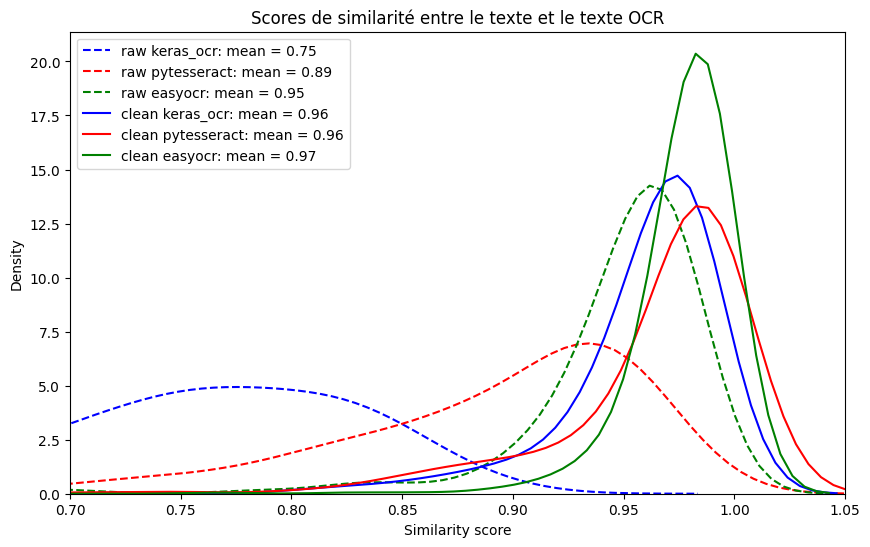

In [22]:
#ploting all the similarity scores
plt.figure(figsize=(10, 6))
plt.xlim(0.7,1.05)
sns.kdeplot(data=df, x="similarity_keras_ocr", color='blue', linestyle='dashed', label='raw keras_ocr: mean = ' + str(round(np.mean(df.similarity_keras_ocr), 2)))
sns.kdeplot(data=df, x="similarity_tess", color='red', linestyle='dashed', label='raw pytesseract: mean = ' + str(round(np.mean(df.similarity_tess), 2)))
sns.kdeplot(data=df, x="similarity_easyocr", color='green', linestyle='dashed', label='raw easyocr: mean = ' + str(round(np.mean(df.similarity_easyocr), 2)))
sns.kdeplot(data=df, x="clean_similarity_keras_ocr", color='blue', label='clean keras_ocr: mean = ' + str(round(np.mean(df.clean_similarity_keras_ocr), 2)))
sns.kdeplot(data=df, x="clean_similarity_tess", color='red', label='clean pytesseract: mean = ' + str(round(np.mean(df.clean_similarity_tess), 2)))
sns.kdeplot(data=df, x="clean_similarity_easyocr", color='green', label='clean easyocr: mean = ' + str(round(np.mean(df.clean_similarity_easyocr), 2)))
plt.xlabel('Similarity score')
plt.title('Scores de similarité entre le texte et le texte OCR')
plt.legend()
plt.show()

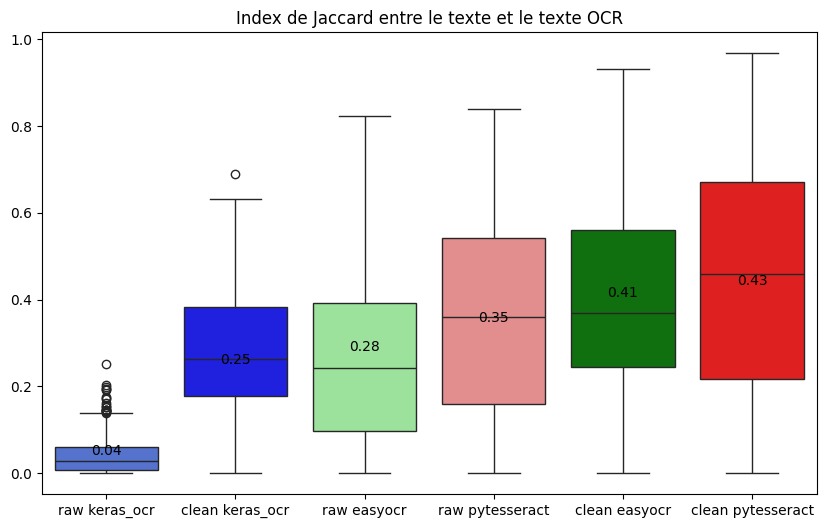

In [23]:
#ploting all the jaccard index
plt.figure(figsize=(10, 6))
sns.boxplot(data=[df.jaccard_keras_ocr, df.jaccard_easyocr, df.clean_jaccard_keras_ocr, df.jaccard_tess, df.clean_jaccard_easyocr, df.clean_jaccard_tess],
            palette=['royalblue','blue','lightgreen','lightcoral','green','red'])
plt.xticks([0, 1, 2, 3, 4, 5], ['raw keras_ocr', 'clean keras_ocr', 'raw easyocr', 'raw pytesseract', 'clean easyocr', 'clean pytesseract'])
plt.text(0, np.mean(df.jaccard_keras_ocr), str(round(np.mean(df.jaccard_keras_ocr), 2)), ha='center')
plt.text(1, np.mean(df.clean_jaccard_keras_ocr), str(round(np.mean(df.clean_jaccard_keras_ocr), 2)), ha='center')
plt.text(2, np.mean(df.jaccard_easyocr), str(round(np.mean(df.jaccard_easyocr), 2)), ha='center')
plt.text(3, np.mean(df.jaccard_tess), str(round(np.mean(df.jaccard_tess), 2)), ha='center')
plt.text(4, np.mean(df.clean_jaccard_easyocr), str(round(np.mean(df.clean_jaccard_easyocr), 2)), ha='center')
plt.text(5, np.mean(df.clean_jaccard_tess), str(round(np.mean(df.clean_jaccard_tess), 2)), ha='center')
plt.title('Index de Jaccard entre le texte et le texte OCR')
plt.show()

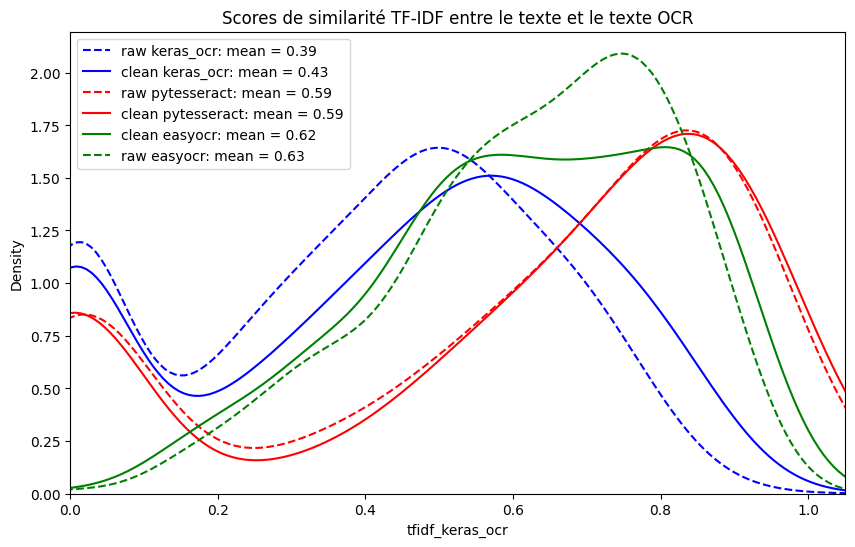

In [25]:
#ploting all the tfidf similarity
plt.figure(figsize=(10, 6))
plt.xlim(0,1.05)
sns.kdeplot(data=df, x="tfidf_keras_ocr", color='blue', linestyle='dashed', label='raw keras_ocr: mean = ' + str(round(np.mean(df.tfidf_keras_ocr), 2)))
sns.kdeplot(data=df, x="clean_tfidf_keras_ocr", color='blue', label='clean keras_ocr: mean = ' + str(round(np.mean(df.clean_tfidf_keras_ocr), 2)))
sns.kdeplot(data=df, x="tfidf_tess", color='red', linestyle='dashed', label='raw pytesseract: mean = ' + str(round(np.mean(df.tfidf_tess), 2)))
sns.kdeplot(data=df, x="clean_tfidf_tess", color='red', label='clean pytesseract: mean = ' + str(round(np.mean(df.clean_tfidf_tess), 2)))
sns.kdeplot(data=df, x="clean_tfidf_easyocr", color='green', label='clean easyocr: mean = ' + str(round(np.mean(df.clean_tfidf_easyocr), 2)))
sns.kdeplot(data=df, x="tfidf_easyocr", color='green', linestyle='dashed', label='raw easyocr: mean = ' + str(round(np.mean(df.tfidf_easyocr), 2)))
plt.title('Scores de similarité TF-IDF entre le texte et le texte OCR')
plt.legend()
plt.show()

EasyOCR donne les meilleurs résultats la majorité du temps et a en plus moins tendance à avoir des mauvais résulats.